# Training a hadronization net

In [1]:
import random as rnd
import numpy as np

import tensorflow as tf
import tensorflow.keras as keras

import tensorflow.keras.backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Concatenate, Lambda
from tensorflow.keras.layers import Layer, Flatten
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import OneHotEncoder

print(tf.__version__)

2.0.0


In [2]:
# data from HadronizationPrep.ipynb
# align 1 with z, 2 in x-z plane, 3 in xyz
# x_raw = [E1, px1, py1, pz1, E2, px2, py2, pz2, Flavor1, Flavor2]
# y_raw = [Emission (+-1), px3, py3, pz3]
x_raw = np.loadtxt('x_raw.dat')
y_raw = np.loadtxt('y_raw.dat')

In [3]:
# postprocess
for i, x in enumerate(x_raw):
    E1 = x_raw[i,0]
    E2 = x_raw[i,4]
    lE12 = np.log(E1+E2)
    x_raw[i,:8] = x_raw[i,:8]/(E1+E2)
    x_raw[i,8] = lE12 # overwriting x_raw[8]
    y_raw[i,1:4] = y_raw[i,1:4]/(E1+E2)

# Momentum model definition

In [4]:
# this is a permanent dropout layer designed to add a lot of randomness
class PermaDropout(Layer):
    def __init__(self, rate):
        super(PermaDropout, self).__init__()
        self.rate = rate

    def call(self, inputs):
        return tf.nn.dropout(inputs, rate=self.rate)

# this is the definition of our custom loss function
REG_LQCD = 1.0 
REG_LQCD_SQ = REG_LQCD**2
REG_TENS = K.constant(REG_LQCD_SQ,shape=3)
REG_TENS4 = K.constant(REG_LQCD_SQ,shape=4)
BATCH_SIZE = 256
REG_TENSB4 = K.constant(REG_LQCD_SQ,shape=[BATCH_SIZE,4])

# Create a loss function that adds the MSE loss to the mean of all squared activations of a specific layer
# note: definition is asymmetric in penalizing large momenta
def lossx(y_true,y_pred):
    #return 1.-y_true[0]*K.tanh(y_pred[0]) + 0.5*(1.+y_true[0])*K.mean(K.square(y_pred[1:] - y_true[1:])/(K.square(y_true[1:])+REG_TENS), axis=-1)
    return 1.-y_true[0]*K.tanh(y_pred[0]) + 0.5*(1.+y_true[0])*K.mean([0,1,1,1]*K.square(y_pred - y_true)/(K.square(y_true)+REG_TENS4), axis=-1)
        
        
def cust_lossx():    
    def lossx(y_true,y_pred):
        A = y_true[:,0]
        return 1.-A*K.tanh(y_pred[:,0]) + 0.5*(1.+A)*K.mean([0,1,1,1]*K.square(y_pred - y_true)/(K.square(y_true)+REG_TENSB4), axis=-1)

    return lossx

# use cross product
def epsijkchoose(i,j,k):
    if i == j or j == k or k == i:
        return 0
    if i == 0:
        if j == 1:
            return 1
        if j == 2:
            return -1
    if i == 1:
        if j == 2:
            return 1
        if j == 0:
            return -1
    if i == 2:
        if j == 0:
            return 1
        if j == 1:
            return -1
epsijk = np.array([ [ [ epsijkchoose(i,j,k) for k in range(3)] for j in range(3)] for i in range(3)]).astype(np.float32)

def cross(x,y):
    x = x[:,-3:]
    y = y[:,-3:]
    epsijkbatch = K.expand_dims(EPS_IJK,len(x),axis=0)
    epsijkbatch = K.batch_dot(epsijkbatch, x, axes=(2, 1))
    epsijkbatch = K.batch_dot(epsijkbatch, y, axes=(2, 1))
    return epsijkbatch

def normcross(x,y):
    return K.sqrt(K.sum(K.square(cross(x,y))))

def normcross(x,y):
    lx = x[:,2]*y[:,3] - x[:,3]*y[:,2]
    ly = x[:,3]*y[:,1] - x[:,1]*y[:,3]
    lz = x[:,1]*y[:,2] - x[:,2]*y[:,1]
    lsq = np.array(lx*lx + ly*ly + lz*lz)
    return lsq**0.5

def lprod(x,y,i,j):
    return K.batch_dot(x[:,i:i+1],y[:,j:j+1]) - K.batch_dot(x[:,j:j+1],y[:,i:i+1])

def normcross(x,y):
    lx = lprod(x,y,2,3)
    ly = lprod(x,y,3,1)
    lz = lprod(x,y,1,2)
    lsq = K.sqrt(K.square(lx) + K.square(ly) + K.square(lz))
    return K.flatten(lsq)

def rtdot(x,y):
    xdysqrt = K.sqrt(K.batch_dot(y[:,1:4]-x[:,1:4],y[:,1:4]))
    return K.flatten(xdysqrt)

def normdot(x,y):
    xdy = K.batch_dot(y[:,1:4]-x[:,1:4],y[:,1:4])
    return K.flatten(xdy)

def lossx(y_true,y_pred):
    A = y_true[:,0]
    B = 3*A - 2
    yabs = K.sqrt(K.mean([0,1,1,1]*K.square(y_true), axis=-1)+1e-14)
    return 1.-B*K.tanh(y_pred[:,0]) + 0.5*(1.+A)/yabs*(K.mean([0,1,1,1]*K.square(y_pred - y_true), axis=-1) + normdot(y_pred, y_true) + normcross(y_pred, y_true))


def cust_lossx():    
    def lossx(y_true,y_pred):
        A = y_true[:,0]
        if A == -1:
            A = -10
        return 1.-A*K.tanh(y_pred[:,0]) + 0.5*(1.+A)*(K.mean([0,1,1,1]*K.square(y_pred - y_true), axis=-1) + normcross(y_pred, y_true))

    return lossx

In [5]:
print(normdot(np.array([[1,0.0005,0.0005,0.5]]),np.array([[1,0.0005,0.0005,-0.5]])))
print(normcross(np.array([[1,0.005,0.005,0.5]]),np.array([[1,0.0005,0.005,-0.5]])))
lossx(np.array([[-1,0.005,0.005,0.5]]),np.array([[100,0.0005,0.005,-0.5]]))

tf.Tensor([0.5], shape=(1,), dtype=float64)
tf.Tensor([0.0057064], shape=(1,), dtype=float64)


<tf.Tensor: id=199, shape=(1,), dtype=float64, numpy=array([6.])>

In [6]:
TRAINCUT = int((int(0.85*len(x_raw))//BATCH_SIZE) * BATCH_SIZE)
VALCUT = int((int(0.1*len(x_raw))//BATCH_SIZE) * BATCH_SIZE)
TESTCUT = int((int(0.05*len(x_raw))//BATCH_SIZE) * BATCH_SIZE)
print("{} {} {}".format(TRAINCUT,VALCUT,TESTCUT))

# Note with this data, I am assuming it doesn't need to be shuffled, but may wish to do that later
NUM_X = 9

x_train = x_raw[:TRAINCUT,:NUM_X]
y_train = y_raw[:TRAINCUT,:4]

x_val = x_raw[TRAINCUT:TRAINCUT+VALCUT,:NUM_X]
y_val = y_raw[TRAINCUT:TRAINCUT+VALCUT,:4]

x_test = x_raw[-TESTCUT:,:NUM_X]
y_test = y_raw[-TESTCUT:,:4]

513792 60416 30208


# Momentum VAE

In [42]:
class VarAutoEncoder():
    # feature extractor model
    def __init__(self):
        self.z_part12 = 9
        self.z_part3 = 4 
        self.z_dim = 5 
        self._build()
    
    def _build(self):
        part12_input = Input(shape=(self.z_part12,), name='part12_input')
        part3_input = Input(shape=(self.z_part3,), name='part3_input')
        
        # encoder
        enc_cat = Concatenate()([part3_input, part12_input])
        enc = Dense(32, activation='relu')(enc_cat)
        enc = Dense(32, activation='relu')(enc)
        enc = Dense(32, activation='relu')(enc)
        # construct variational aspect
        self.mu = Dense(self.z_dim, name='mu')(enc)
        self.log_var = Dense(self.z_dim, name='log_var')(enc)
        #enc_outprep = Concatenate()([self.mu, self.log_var])
        #self.encoder_mu_log_var = Model([part3_input,part12_input], [self.mu, self.log_var])
        
        def sampling(args):
            mu, log_var = args
            epsilon = K.random_normal(shape=K.shape(mu), mean=0., stddev=1.)
            return mu + K.exp(log_var / 2) * epsilon

        enc_output = Lambda(sampling, name='encoder_output')([self.mu, self.log_var])
        self.encoder = Model([part3_input,part12_input],enc_output)
        
        # decoder
        encoded_input = Input(shape=(self.z_dim,), name='enc_part3_input')
        dec_input = Concatenate()([encoded_input, part12_input])
        dec = Dense(32, activation='relu')(dec_input)
        #PermaDropout(0.5),
        dec = Dense(32, activation='relu')(dec)
        #PermaDropout(0.5),
        dec = Dense(32, activation='relu')(dec)
        #PermaDropout(0.5),
        dec_output = Dense(self.z_part3, activation='linear')(dec)
        self.decoder = Model([encoded_input, part12_input], dec_output)
        
        # the autoencoder
        model_input = [part3_input,part12_input]
        model_output = self.decoder([enc_output,part12_input])

        self.autoencoder = Model(model_input, model_output)
    
    def compile(self, learning_rate):
        self.learning_rate = learning_rate
        optimizer = Adam(lr=learning_rate)
        
        def vae_kl_loss(y_true, y_pred):
            kl_loss =  -0.5 * K.sum(1 + self.log_var - K.square(self.mu) - K.exp(self.log_var), axis = 1)
            return kl_loss
        
        def emission_loss(y_true,y_pred, emitScale = 1.8):
            A = y_true[:,0]
            """ Note: This scale encourages the program to get the emission prob correct.  
                If too small (e.g. 1), it is never favorable.  If too large, e.g. 5 it is always favorable,
                but at the cost of the other part of the loss.
            """
            B = emitScale*A - (emitScale-1)
            yabs = K.sqrt(K.mean([0,1,1,1]*K.square(y_true), axis=-1)+1e-14)
            return 1.-B*K.tanh(10*y_pred[:,0])
        
        def p_mse_loss(y_true,y_pred):
            A = y_true[:,0]
            yabs = K.sqrt(K.mean([0,1,1,1]*K.square(y_true), axis=-1)+1e-14)
            return 0.5*(1.+A)/yabs*(K.mean([0,1,1,1]*K.square(y_pred - y_true), axis=-1))
        
        def p_dot_loss(y_true,y_pred):
            A = y_true[:,0]
            yabs = K.sqrt(K.mean([0,1,1,1]*K.square(y_true), axis=-1)+1e-14)
            return 0.5*(1.+A)/yabs*(K.sqrt(K.square(normdot(y_pred, y_true))))
       
        def p_cross_loss(y_true,y_pred):
            A = y_true[:,0]
            yabs = K.sqrt(K.mean([0,1,1,1]*K.square(y_true), axis=-1)+1e-14)
            return 0.5*(1.+A)/yabs*(normcross(y_pred, y_true))
        
        def lossx(y_true,y_pred, emitScale = 1.5):
            A = y_true[:,0]
            """ Note: This scale encourages the program to get the emission prob correct.  
                If too small (e.g. 1), it is never favorable.  If too large, e.g. 5 it is always favorable,
                but at the cost of the other part of the loss.
            """
            B = emitScale*A - (emitScale-1)
            yabs = K.sqrt(K.mean([0,1,1,1]*K.square(y_true), axis=-1)+1e-14)
            return 1.-B*K.tanh(10*y_pred[:,0]) + 0.5*(1.+A)/yabs*(K.mean([0,1,1,1]*K.square(y_pred - y_true), axis=-1) + normcross(y_pred, y_true))
        
        def vae_loss(y_true, y_pred, scale = 1):
            loss_x = lossx(y_true, y_pred)
            kl_loss = vae_kl_loss(y_true, y_pred)
            return  scale*loss_x + kl_loss
        
        """ Here, I need to set experimental_run_tf_function=False in order for this to execute.
            I do not know why exactly, but with a TF2 upgrade this may go away. See discussion:
            https://github.com/tensorflow/probability/issues/519
        """
        self.autoencoder.compile(optimizer=optimizer, loss = vae_loss, 
                                 metrics = [vae_kl_loss, lossx, emission_loss, p_cross_loss,p_mse_loss],
                                experimental_run_tf_function=False)
        
    def train(self, x_train, y_train, batch_size, epochs, validation_data=None):
        
        if validation_data is not None:
            x_val = validation_data[0]
            y_val = validation_data[1]
            validation_data=[[y_val,x_val],y_val]

        self.autoencoder.fit([y_train, x_train], 
                             y_train,
                             batch_size = batch_size,
                             shuffle = True,
                             epochs = epochs,
                             validation_data=validation_data)

In [43]:
var_auto_encoder = VarAutoEncoder()

In [44]:
LEARNING_RATE = 0.001
var_auto_encoder.compile(LEARNING_RATE)

In [45]:
var_auto_encoder.train(x_train, y_train, 128, 15, validation_data=[x_val,y_val])

Train on 513792 samples, validate on 60416 samples
Epoch 1/15
513792/513792 [==============================] - 53s 104us/sample - loss: 0.8116 - vae_kl_loss: 0.1920 - lossx: 0.6196 - emission_loss: 0.0893 - p_cross_loss: 0.0310 - p_mse_loss: 0.4643 - val_loss: 0.3809 - val_vae_kl_loss: 0.2654 - val_lossx: 0.1156 - val_emission_loss: -0.0940 - val_p_cross_loss: 0.0193 - val_p_mse_loss: 0.1143
Epoch 2/15
513792/513792 [==============================] - 49s 94us/sample - loss: 0.3522 - vae_kl_loss: 0.2201 - lossx: 0.1322 - emission_loss: -0.0537 - p_cross_loss: 0.0130 - p_mse_loss: 0.1086 - val_loss: 0.3256 - val_vae_kl_loss: 0.2022 - val_lossx: 0.1235 - val_emission_loss: -0.0328 - val_p_cross_loss: 0.0092 - val_p_mse_loss: 0.0920
Epoch 3/15
513792/513792 [==============================] - 49s 96us/sample - loss: 0.3171 - vae_kl_loss: 0.2157 - lossx: 0.1014 - emission_loss: -0.0695 - p_cross_loss: 0.0093 - p_mse_loss: 0.0940 - val_loss: 0.3182 - val_vae_kl_loss: 0.2553 - val_lossx: 0.062

In [47]:
idx = 24
xs = x_train[idx:idx+1]
ys = y_train[idx:idx+1]
enc_out = var_auto_encoder.encoder.predict([ys,xs])
dec_out = var_auto_encoder.decoder.predict([enc_out,xs])
print(xs)
print(ys)
print(enc_out)
print(dec_out)
print(ys)

[[ 8.27929256e-01 -1.45183586e-02 -4.43406297e-03  8.27755715e-01
   1.72070744e-01  4.14043719e-03  5.31030553e-03  1.71862873e-01
   4.17234429e+00]]
[[ 1.00000000e+00 -4.10153546e-03 -1.47013246e-04  7.26547156e-02]]
[[ 1.5170076  -0.92573345 -0.33541608  0.51209533  0.74094313]]
[[ 1.8590106e+00 -7.2997529e-05  9.4305165e-04  2.3578215e-01]]
[[ 1.00000000e+00 -4.10153546e-03 -1.47013246e-04  7.26547156e-02]]


# Boosting

In [21]:
import sys
PYTHIA_PATH = '/Users/JAE/Desktop/Apps/pythia8243/'
cfg = open(PYTHIA_PATH +"examples/Makefile.inc")
lib = PYTHIA_PATH +"lib/"
for line in cfg:
    if line.startswith("PREFIX_LIB="): lib = line[11:-1]; break
sys.path.insert(0, lib)
import math
import numpy, pythia8

ModuleNotFoundError: No module named '_pythia8'

# Momentum AE

In [91]:
class AutoEncoder():
    # feature extractor model
    def __init__(self):
        self.z_part12 = 8 
        self.z_part3 = 4 
        self.z_dim = 3 
        self._build()
    
    def _build(self):
        part12_input = Input(shape=(self.z_part12,), name='part12_input')
        part3_input = Input(shape=(self.z_part3,), name='part3_input')
        
        # encoder
        enc_cat = Concatenate()([part3_input, part12_input])
        enc = Dense(32, activation='relu')(enc_cat)
        enc = Dense(32, activation='relu')(enc)
        enc = Dense(32, activation='relu')(enc)
        encoded = Dense(self.z_dim, activation='linear')(enc)
        self.encoder = Model([part3_input,part12_input],encoded)
        
        # decoder
        encoded_input = Input(shape=(self.z_dim,), name='enc_part3_input')
        dec_input = Concatenate()([encoded_input, part12_input])
        dec = Dense(64, activation='relu')(dec_input)
        #PermaDropout(0.5),
        dec = Dense(64, activation='relu')(dec)
        #PermaDropout(0.5),
        dec = Dense(64, activation='relu')(dec)
        #PermaDropout(0.5),
        dec_output = Dense(self.z_part3, activation='linear')(dec)
        self.decoder = Model([encoded_input, part12_input], dec_output)
        
        # the autoencoder
        model_input = [part3_input,part12_input]
        model_output = self.decoder([encoded,part12_input])

        self.autoencoder = Model(model_input, model_output)
    
    def compile(self, learning_rate):
        self.learning_rate = learning_rate
        optimizer = Adam(lr=learning_rate)
        
        def lossx(y_true,y_pred):
            A = y_true[:,0]
            yabs = K.sqrt(K.mean([0,1,1,1]*K.square(y_true), axis=-1)+1e-14)
            return 1.-A*K.tanh(y_pred[:,0]) + 0.5*(1.+A)/yabs*(K.mean([0,1,1,1]*K.square(y_pred - y_true), axis=-1) + normdot(y_pred, y_true) + normcross(y_pred, y_true))
        
        self.autoencoder.compile(optimizer=optimizer, loss = lossx)
        
    def train(self, x_train, y_train, batch_size, epochs, validation_data=None):
        
        if validation_data is not None:
            x_val = validation_data[0]
            y_val = validation_data[1]
            validation_data=[[y_val,x_val],y_val]

        self.autoencoder.fit([y_train, x_train], 
                             y_train,
                             batch_size = batch_size,
                             shuffle = True,
                             epochs = epochs,
                             validation_data=validation_data
                            
        )

In [92]:
auto_encoder = AutoEncoder()

In [93]:
LEARNING_RATE = 0.001
auto_encoder.compile(LEARNING_RATE)

In [94]:
auto_encoder.train(x_train, y_train, 128, 15, validation_data=[x_val,y_val])

Train on 513792 samples, validate on 60416 samples
Epoch 1/15
513792/513792 [==============================] - 30s 59us/sample - loss: 1.0019 - val_loss: 0.7041
Epoch 2/15
513792/513792 [==============================] - 32s 62us/sample - loss: 0.5596 - val_loss: 0.3340
Epoch 3/15
513792/513792 [==============================] - 30s 59us/sample - loss: 0.4461 - val_loss: 0.3782
Epoch 4/15
513792/513792 [==============================] - 30s 58us/sample - loss: 0.3584 - val_loss: 0.8633
Epoch 5/15
513792/513792 [==============================] - 30s 58us/sample - loss: 0.3065 - val_loss: 0.4606
Epoch 6/15
513792/513792 [==============================] - 30s 58us/sample - loss: 0.2541 - val_loss: 0.2671
Epoch 7/15
513792/513792 [==============================] - 30s 59us/sample - loss: 0.2281 - val_loss: 0.2101
Epoch 8/15
513792/513792 [==============================] - 30s 58us/sample - loss: 0.2937 - val_loss: 0.3135
Epoch 9/15
513792/513792 [==============================] - 30s 59us/

In [69]:
idx = 23
xs = x_train[idx:idx+1]
ys = y_train[idx:idx+1]
enc_out = auto_encoder.encoder.predict([ys,xs])
dec_out = auto_encoder.decoder.predict([enc_out,xs])
print(xs)
print(ys)
print(enc_out)
print(dec_out)
print(ys)

NameError: name 'auto_encoder' is not defined

# Initial momentum model

In [132]:
def define_momentum_model():
    # feature extractor model
    model = Sequential([
        Dense(64, activation='relu',input_shape=[8]),
        PermaDropout(0.5),
        Dense(64, activation='relu'),
        PermaDropout(0.5),
        Dense(4, activation='linear')
        ])
    print(model.summary())
    # Compile the model
    model.compile(optimizer='adam',loss=cust_lossx())
    return model

In [133]:
model = define_momentum_model()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 64)                576       
_________________________________________________________________
perma_dropout_18 (PermaDropo (None, 64)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 64)                4160      
_________________________________________________________________
perma_dropout_19 (PermaDropo (None, 64)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 4)                 260       
Total params: 4,996
Trainable params: 4,996
Non-trainable params: 0
_________________________________________________________________
None


In [134]:
model.optimizer.lr = 0.001

## Training momentum model

In [136]:
history = model.fit(x_train, y_train, epochs=30, batch_size = BATCH_SIZE, validation_data=[x_val,y_val])

Train on 513792 samples, validate on 60416 samples
Epoch 1/30
513792/513792 [==============================] - 24s 48us/sample - loss: 0.3210 - val_loss: 0.3052
Epoch 2/30
513792/513792 [==============================] - 21s 42us/sample - loss: 0.3029 - val_loss: 0.3034
Epoch 3/30
513792/513792 [==============================] - 22s 43us/sample - loss: 0.3019 - val_loss: 0.3030
Epoch 4/30
513792/513792 [==============================] - 23s 44us/sample - loss: 0.3015 - val_loss: 0.3024
Epoch 5/30
513792/513792 [==============================] - 21s 42us/sample - loss: 0.3012 - val_loss: 0.3023
Epoch 6/30
 17152/513792 [>.............................] - ETA: 20s - loss: 0.2986

KeyboardInterrupt: 

In [145]:
idx = 202
print(x_train[idx])
print(y_train[idx])
print(model.predict(x_train[idx:idx+1]))

[ 0.18513115 -0.00340915  0.00204126  0.18502525  0.81486885  0.00235271
  0.00728108 -0.81481431]
[ 1.00000000e+00 -7.78584587e-04  3.80717898e-03  1.37925427e-01]
[[6.6870565e+00 6.9317431e-04 1.5475576e-04 1.5962045e-03]]


In [144]:
idx = 102
print(x_train[idx])
print(y_train[idx])
print(model.predict(x_train[idx:idx+1]))

[ 5.46594976e-01 -1.42339427e-01  4.69652409e-03  5.27704385e-01
  4.53405024e-01 -3.32098278e-01  5.41031581e-04 -3.08685196e-01]
[-1.  0.  0.  0.]
[[9.3255873e+00 8.0299063e-04 1.2794735e-03 6.3834339e-02]]


# Flavor model definition

In [37]:
TRAINCUT = int((int(0.85*len(x_raw))//BATCH_SIZE) * BATCH_SIZE)
VALCUT = int((int(0.1*len(x_raw))//BATCH_SIZE) * BATCH_SIZE)
TESTCUT = int((int(0.05*len(x_raw))//BATCH_SIZE) * BATCH_SIZE)
print("{} {} {}".format(TRAINCUT,VALCUT,TESTCUT))

# Note with this data, I am assuming it doesn't need to be shuffled, but may wish to do that later

encin = OneHotEncoder(sparse = False)
xf_ohe = encin.fit_transform(x_raw[:,8:].astype(int))

encout = OneHotEncoder(sparse = False)
yf_ohe = encout.fit_transform(y_raw[:,4:].astype(int))

xf_train = xf_ohe[:TRAINCUT]
yf_train = yf_ohe[:TRAINCUT]

xf_val = xf_ohe[TRAINCUT:TRAINCUT+VALCUT]
yf_val = yf_ohe[TRAINCUT:TRAINCUT+VALCUT]

xf_test = xf_ohe[-TESTCUT:]
yf_test = yf_ohe[-TESTCUT:]

513920 60416 30208


In [46]:
nIn = xf_ohe.shape[1]

In [38]:
yf_train.shape

(513920, 89)

In [39]:
inflavorset = [ 21, 1,-1,2,-2,3,-3 ]
outflavorset = [ ]
for x in x_raw[:,8:]:
    for y in x:
        if y not in inflavorset:
            inflavorset.append(y)

for y in y_raw[:,4]:
    if y not in outflavorset:
        outflavorset.append(y)

nInStates = len(inflavorset)
nOutStates = len(outflavorset)

In [47]:
def define_flavor_model():
    # feature extractor model
    inputs = Input(shape=(nIn,))
    l1 = Dense(64, activation='relu')(inputs)
    l2 = Dense(64, activation='relu')(l1)
    outputs = Dense(nOutStates, activation='softmax')(l2)
    model = Model(inputs=inputs, outputs=outputs)
    print(model.summary())
    # Compile the model
    model.compile(optimizer='adam',loss='categorical_crossentropy')
    return model

In [48]:
flavormodel=define_flavor_model()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 39)]              0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                2560      
_________________________________________________________________
dense_8 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_9 (Dense)              (None, 89)                5785      
Total params: 12,505
Trainable params: 12,505
Non-trainable params: 0
_________________________________________________________________
None


In [50]:
history = flavormodel.fit(xf_train, yf_train, epochs=30, batch_size = BATCH_SIZE, validation_data=[xf_val,yf_val])

Train on 513920 samples, validate on 60416 samples
Epoch 1/30
513920/513920 [==============================] - 29s 56us/sample - loss: 2.2018 - val_loss: 2.1454
Epoch 2/30
513920/513920 [==============================] - 30s 58us/sample - loss: 2.1457 - val_loss: 2.1407
Epoch 3/30
513920/513920 [==============================] - 36s 70us/sample - loss: 2.1427 - val_loss: 2.1407
Epoch 4/30
513920/513920 [==============================] - 32s 63us/sample - loss: 2.1409 - val_loss: 2.1375
Epoch 5/30
513920/513920 [==============================] - 32s 62us/sample - loss: 2.1392 - val_loss: 2.1378
Epoch 6/30
513920/513920 [==============================] - 31s 60us/sample - loss: 2.1378 - val_loss: 2.1378
Epoch 7/30
513920/513920 [==============================] - 28s 55us/sample - loss: 2.1368 - val_loss: 2.1365
Epoch 8/30
513920/513920 [==============================] - 32s 61us/sample - loss: 2.1363 - val_loss: 2.1366
Epoch 9/30
513920/513920 [==============================] - 32s 62us/

In [51]:
yf_train.shape

(513920, 89)

# Plotting

In [55]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [48]:
x_raw = np.loadtxt('x_raw.dat')
y_raw = np.loadtxt('y_raw.dat')

In [191]:
filex = open('/Users/JAE/Desktop/Python/PythiaGAN/HadronizationMultiplicity.dat',"r")
hstr = filex.readline()
filex.close()
multlist = hstr.strip("[]").split(",")
multlist = [ int(x) for x in multlist[1:] ]

In [254]:
pred_train = var_auto_encoder.decoder.predict([tf.random.normal(shape=[len(x_train),5]),x_train])
pred_val = var_auto_encoder.decoder.predict([tf.random.normal(shape=[len(x_val),5]),x_val])
pred_test = var_auto_encoder.decoder.predict([tf.random.normal(shape=[len(x_test),5]),x_test])
pred_all = np.concatenate((pred_train, pred_val,pred_test), axis=0)

ValueError: operands could not be broadcast together with shapes (513792,4) (60416,4) 

In [260]:
x_all = np.concatenate((x_train, x_val,x_test), axis=0)

In [284]:
def E_fraction(x,y, isLinear = False):
    E12 = x[:,0]+x[:,4]
    E3 = np.sqrt(np.sum(y[:,1:4]**2,axis=-1))
    z = [10 if k[0] < 0 else 0 for k in y] 
    if isLinear:
        return E3/E12
    else:
        return np.log(E3/E12+1e-5+z)/np.log(10)
    
def angles(x,y, isLinear = False):
    p1 = x[:,1:4]
    p2 = x[:,5:8]
    p3 = y[:,1:4]
    z = [10 if k[0] < 0 else 0 for k in y] 
    ctheta = np.sum(p1*p3,axis=-1)/np.sqrt(np.sum(p1*p1+1e-8,axis=-1)*np.sum(p3*p3+1e-8,axis=-1))
    if isLinear:
        return ctheta
    else:
        return np.log(1-ctheta+1e-8+z)/np.log(10)
    
def angle_from_cm(x,y, isLinear = False):
    pcm = x[:,1:4]+x[:,5:8]
    p3 = y[:,1:4]
    z = [10 if k[0] < 0 else 0 for k in y]  
    ctheta = np.sum(pcm*p3,axis=-1)/np.sqrt(np.sum(pcm*pcm+1e-8,axis=-1)*np.sum(p3*p3+1e-8,axis=-1))
    if isLinear:
        return ctheta
    else:
        return np.log(1-ctheta+1e-8+z)/np.log(10)

In [285]:
Es = E_fraction(x_raw,y_raw)
cthe =  angles(x_raw,y_raw)
cthecm = angle_from_cm(x_raw,y_raw)

In [286]:
Es_new = E_fraction(x_all,pred_all)
cthe_new =  angles(x_all,pred_all)
cthecm_new = angle_from_cm(x_all,pred_all)

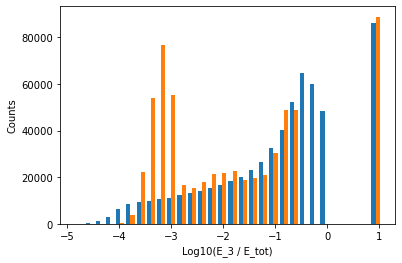

In [287]:
plt.hist((Es,Es_new),bins =30)
plt.xlabel("Log10(E_3 / E_tot)")
plt.ylabel("Counts")
plt.show()

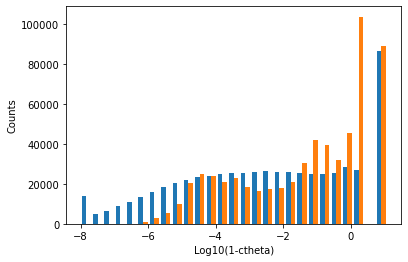

In [288]:
plt.hist((cthe,cthe_new),bins=27)
plt.xlabel("Log10(1-ctheta)")
plt.ylabel("Counts")
plt.show()

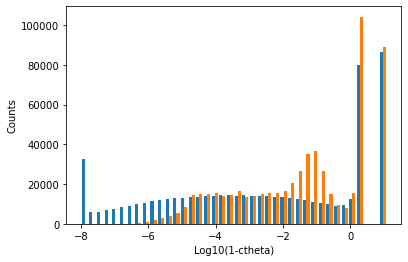

In [289]:
plt.hist((cthecm,cthecm_new),bins=40)
plt.xlabel("Log10(1-ctheta)")
plt.ylabel("Counts")
plt.show()

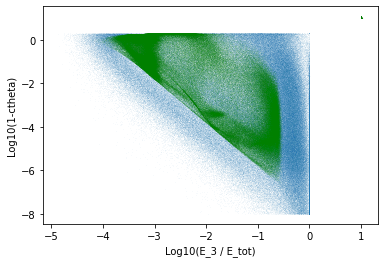

In [290]:
plt.scatter(Es,cthe,s=0.0005,marker=".")
plt.scatter(Es_new,cthe_new,s=0.0005,marker=".",color="g")
plt.ylabel("Log10(1-ctheta)")
plt.xlabel("Log10(E_3 / E_tot)")
plt.show()

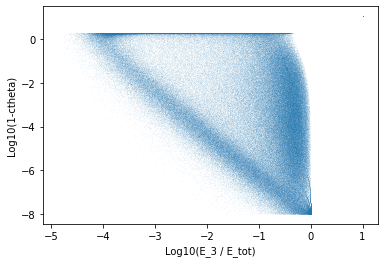

In [291]:
plt.scatter(Es,cthecm,s=0.0005,marker=".")
plt.ylabel("Log10(1-ctheta)")
plt.xlabel("Log10(E_3 / E_tot)")
plt.show()

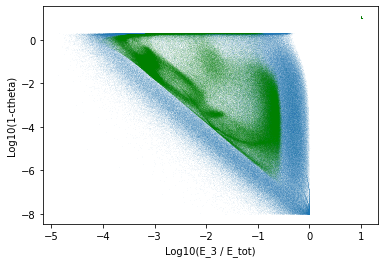

In [292]:
plt.scatter(Es,cthecm,s=0.0005,marker=".")
plt.scatter(Es_new,cthecm_new,s=0.0005,marker=".",color="g")
plt.ylabel("Log10(1-ctheta)")
plt.xlabel("Log10(E_3 / E_tot)")
plt.show()

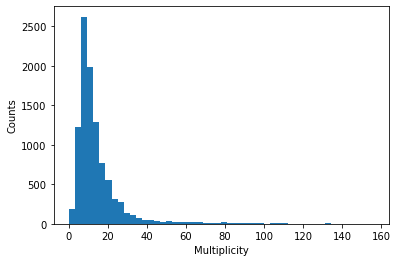

In [283]:
plt.hist(multlist,bins=50)
plt.xlabel("Multiplicity")
plt.ylabel("Counts")
plt.show()